In [1]:
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
cocoapi_dir = "C:/Users/ExplosiveTurkey/image_captioning"

# Defining a transform to pre-process the testing images.
transform_test = transforms.Compose(
    [
        transforms.Resize(256),  # smaller edge of image resized to 256
        transforms.RandomCrop(224),  # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),  # horizontally flip image with probability=0.5
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)


# Creating the data loader.
data_loader = get_loader(transform=transform_test, mode="test", cocoapi_loc=cocoapi_dir)

Vocabulary successfully loaded from vocab.pkl file!


torch.Size([1, 640, 453, 3]) torch.Size([1, 3, 224, 224]) torch.Size([640, 453, 3])


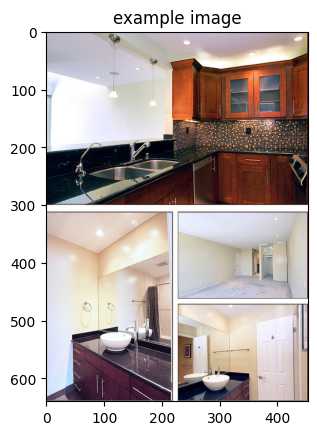

In [3]:
# Obtaining sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

print(orig_image.shape, image.shape, np.squeeze(orig_image).shape)

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title("example image")
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Specify the saved models to load.
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.eval()
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), map_location=torch.device('cpu')))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

In [6]:
# Moving image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtaining the embedded image features.
features = encoder(image).unsqueeze(1)

print(features.shape)
# Passing the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print("example output:", output)

assert type(output) == list, "Output needs to be a Python list"
assert all([type(x) == int for x in output]), "Output should be a list of integers."
assert all(
    [x in data_loader.dataset.vocab.idx2word for x in output]
), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 1, 256])
example output: [0, 3, 10, 21, 3, 56, 6, 3, 152, 1]


In [7]:
sentence = clean_sentence(output, data_loader.dataset.vocab.idx2word)
print("example sentence:", sentence)

assert type(sentence) == str, "Sentence needs to be a Python string!"

example sentence:  a bathroom with a sink and a mirror


In [8]:
def get_prediction(idx2word, i=0, save=False):
    orig_image, image = next(iter(data_loader))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)

    ax = plt.axes()
    # remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Hide ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence, fontsize=12)
    if save:
        plt.savefig(f"samples/sample_{i:03}.png", bbox_inches="tight")
    plt.show()

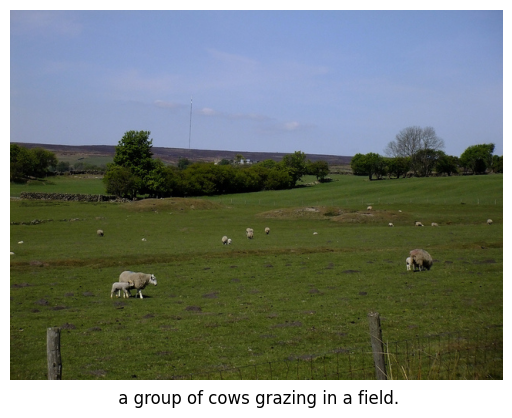

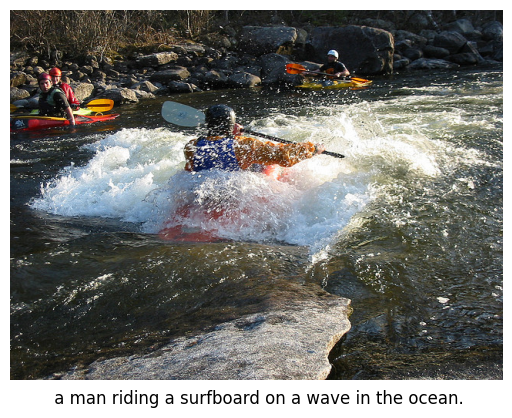

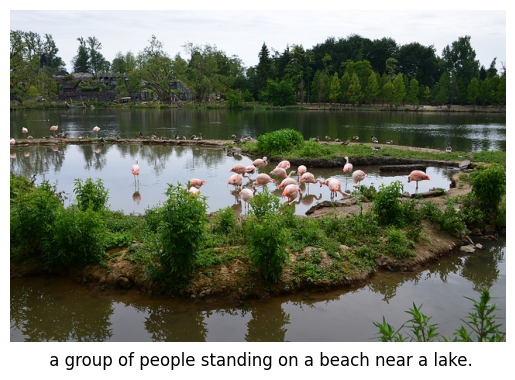

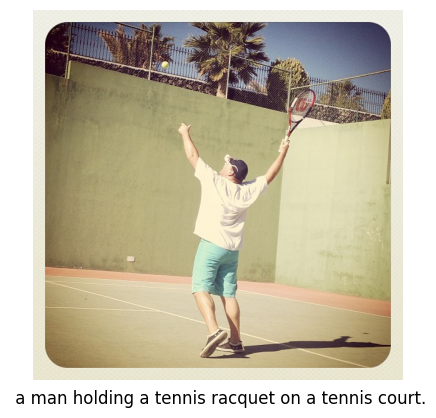

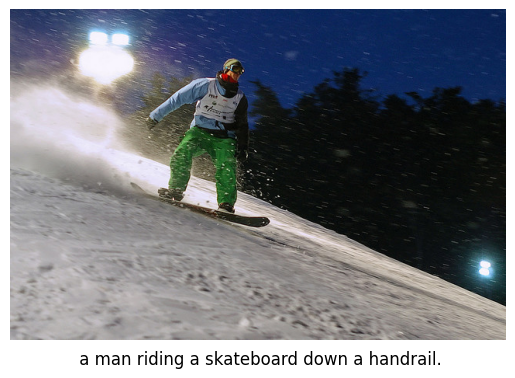

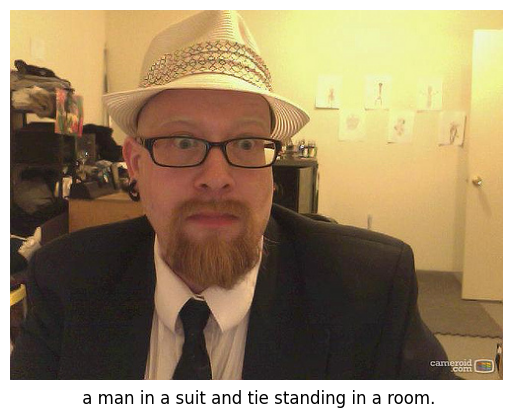

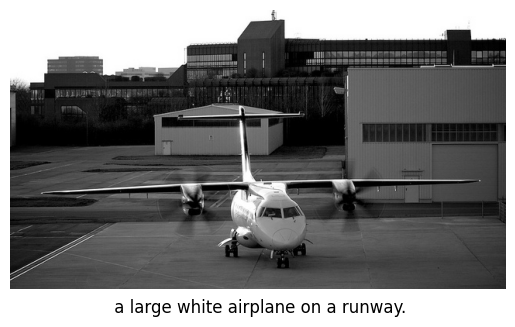

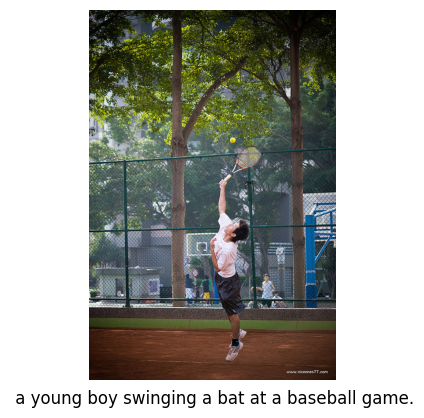

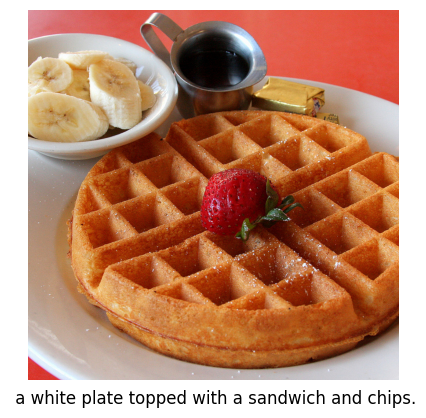

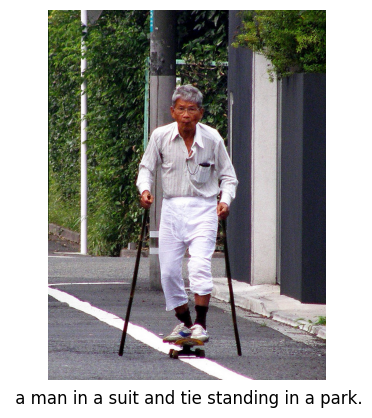

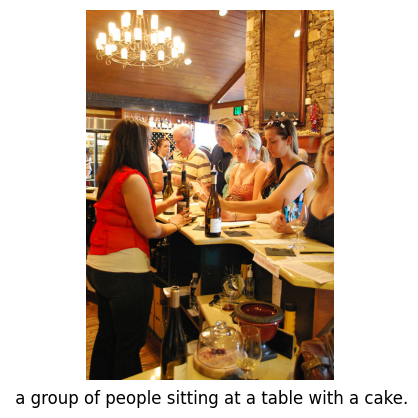

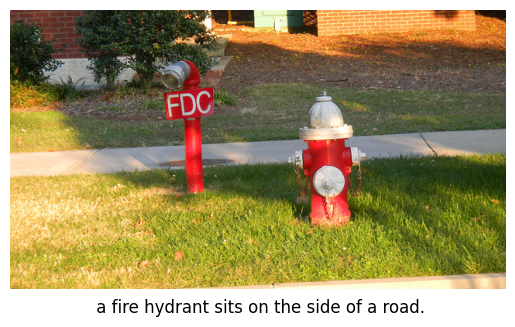

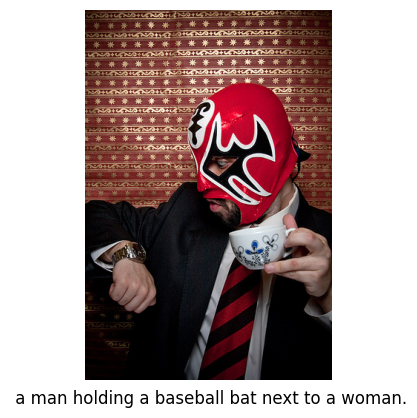

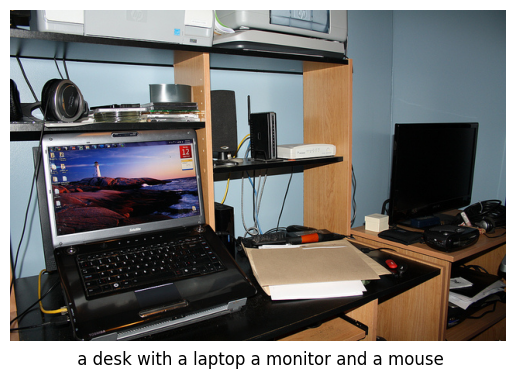

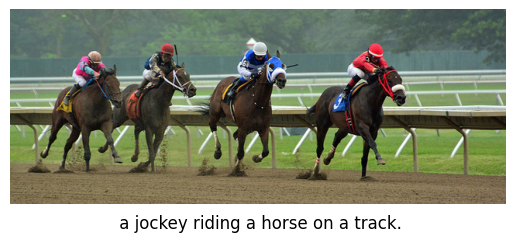

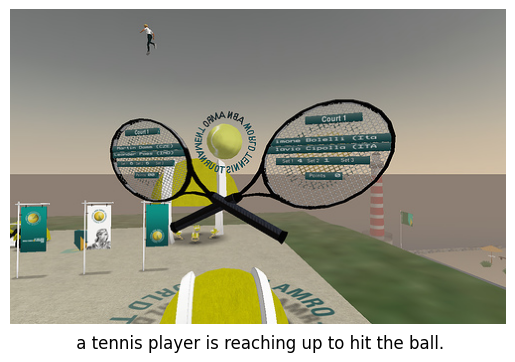

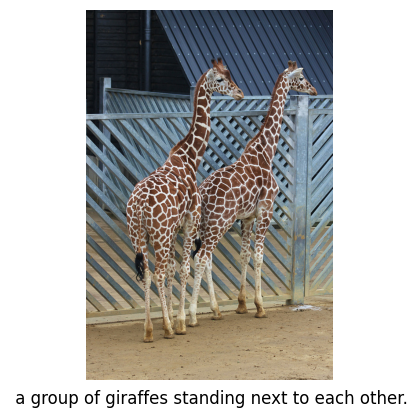

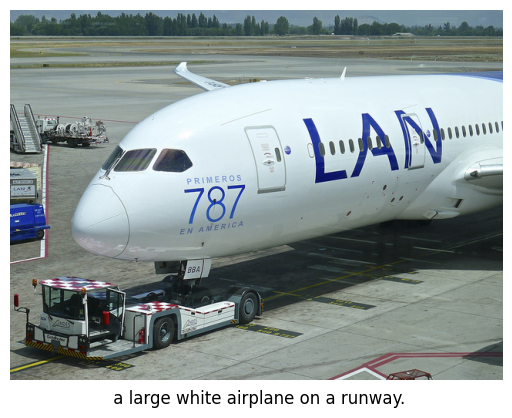

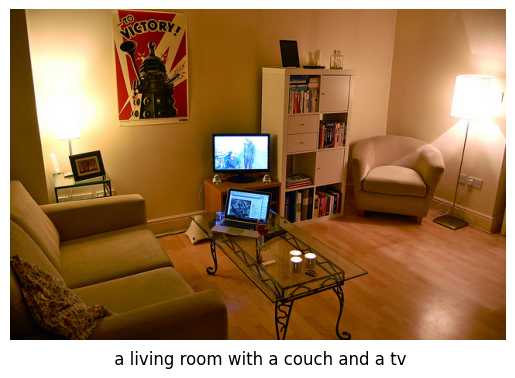

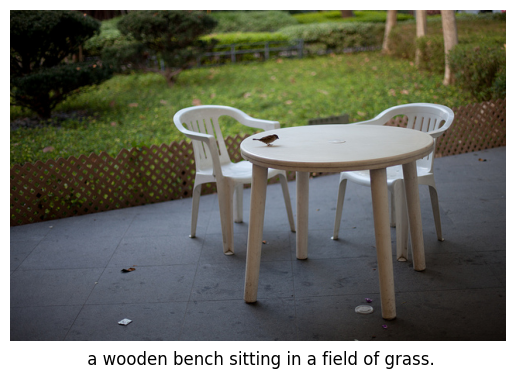

In [12]:
for i in range(20):
    get_prediction(data_loader.dataset.vocab.idx2word, i=i)